<a href="https://colab.research.google.com/github/Sharad27-best/UFC-sentiment-analysis/blob/main/UFC_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
file_path = "/content/ufc_comments.csv"
df = pd.read_csv(file_path)

In [3]:
# Ensure required columns exist
required_columns = {'Comment', 'Sentiment'}
if not required_columns.issubset(df.columns):
    print("Error: Required columns not found in dataset")
    exit()

In [4]:
# Drop unnecessary columns
df = df[['Comment', 'Sentiment']].dropna()

# Convert labels to numerical format
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
df['Sentiment_Label'] = df['Sentiment'].map(sentiment_mapping)

In [5]:
# Check for invalid labels
if df['Sentiment_Label'].isnull().any():
    print("Error: Dataset contains invalid sentiment labels")
    exit()

In [6]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokens = tokenizer(df["Comment"].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(tokens['input_ids'], df['Sentiment_Label'].values, test_size=0.2, random_state=42)
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

In [8]:
# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], torch.tensor(self.data[idx][1], dtype=torch.long)

train_loader = DataLoader(SentimentDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(SentimentDataset(test_data), batch_size=16)


In [9]:
# Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from transformers import get_scheduler

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Update for 5 epochs
num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Mixed Precision
scaler = GradScaler()

# Improved Training Loop for 5 epochs
def train_model(model, train_loader, epochs=5, accumulation_steps=2):  # 5 epochs
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct, total = 0, 0  # Track accuracy

        for step, batch in enumerate(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():
                outputs = model(inputs, labels=labels)
                loss = outputs.loss / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                lr_scheduler.step()

            total_loss += loss.item() * accumulation_steps

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total * 100
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

# Run optimized training
train_model(model, train_loader)


<ipython-input-10-661ad628693a>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-10-661ad628693a>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1: Loss = 0.6533, Accuracy = 72.56%
Epoch 2: Loss = 0.3344, Accuracy = 88.83%
Epoch 3: Loss = 0.2045, Accuracy = 93.76%
Epoch 4: Loss = 0.1408, Accuracy = 95.95%
Epoch 5: Loss = 0.0986, Accuracy = 97.20%



Test Accuracy: 0.9212
R² Score: 0.7248

Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83       353
    Positive       0.92      0.94      0.93       840
     Neutral       0.95      0.94      0.95       951

    accuracy                           0.92      2144
   macro avg       0.90      0.90      0.90      2144
weighted avg       0.92      0.92      0.92      2144



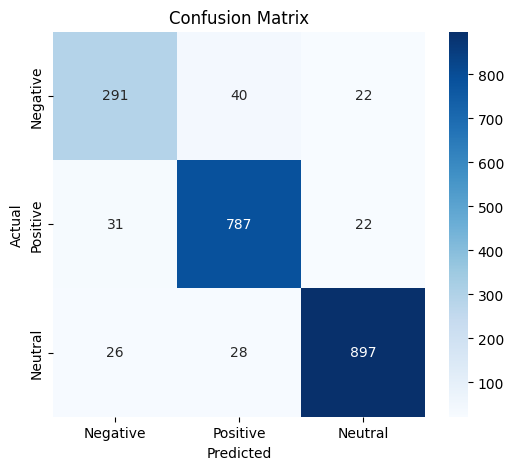

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# Updated Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(F.softmax(outputs.logits, dim=1), dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    r2 = r2_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive', 'Neutral'])

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("\nClassification Report:\n", report)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral'],
                yticklabels=['Negative', 'Positive', 'Neutral'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Call the updated function
evaluate_model(model, test_loader)


In [12]:
# Predict sentiment for new comments
def predict_sentiment(model, comments):
    model.eval()
    tokens = tokenizer(comments, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(tokens['input_ids'])
        predictions = torch.argmax(F.softmax(outputs.logits, dim=1), dim=1).cpu().numpy()
    sentiment_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    return [sentiment_labels[pred] for pred in predictions]

In [13]:
# Example predictions
new_comments = [
    "This fight good !"

  ]
predictions = predict_sentiment(model, new_comments)
for comment, sentiment in zip(new_comments, predictions):
    print(f"Comment: {comment} => Sentiment: {sentiment}")


Comment: This fight good ! => Sentiment: Positive


In [14]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --clear-output --inplace UFC_sentiment_analysis_.ipynb


[NbConvertApp] WARNING | pattern 'UFC_sentiment_analysis_.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-